# Two-Tone Spectroscopy

***Collin Bradford***

This example outputs a constant tone on one channel (the cavity channel) and performs a frequency sweep on the second channel (the qubit channel). Although in a real application, ony the cavity channel would be read out, for demonstration purposes, both ADC channels are read out. 

The recommend configuration is to attach output channel 7 to input channel 0 and channel 6 to input channel 1. Adding a filter through one of the channels also makes it easier to identify the individual channels on the return waveforms. 

Channels and frequency selections can be made in the bottom cell. 



In [1]:
import matplotlib.pyplot as plt

from pynq import Overlay
import numpy as np

from qsystem_2 import *
from qsystem2_asm import *

In [2]:
# Signal Generator V4.
# 31  ..   0 : frequency.
# 63  ..  32 : phase.
# 79  ..  64 : addr.
# 95  ..  80 : xxxx (not used).
# 111 ..  96 : gain.
# 127 .. 112 : xxxx (not used).
# 143 .. 128 : nsamp.
# 145 .. 144 : outsel  (00: product, 01: dds, 10: table, 11: zero value).
#        146 : mode    (0: nsamp, 1: periodic).
#        147 : stdysel (0: last value, 1: zero value).
#        148 : phrst   (not implemented yet).
# 159 .. 149 : xxxx (not used).

#ASM 2.0 for DDS Frequency Visualization
soc = PfbSoc('qsystem_2.bit', force_init_clks=False)
with ASM_Program() as p:
    #Write all memory addresses to program memory
    p.memri(1,1,0,"Loop")
    #Set the frequencies for each channel
    p.memri(0,1,1,"freq ch 1")
    p.memri(0,2,2,"freq ch 2")
    p.memri(0,3,3,"freq ch 3")
    p.memri(0,4,4,"freq ch 4")
    p.memri(0,5,5,"freq ch 5")
    p.memri(0,6,6,"freq ch 6")
    p.memri(0,7,7,"freq ch 7")
    #Set the gain values for each channel
    p.memri(0,8,8,"gain ch 1")
    p.memri(0,9,9,"gain ch 2")
    p.memri(0,10,10,"gain ch 3")
    p.memri(0,11,11,"gain ch 4")
    p.memri(0,12,12,"gain ch 5")
    p.memri(0,13,13,"gain ch 6")
    p.memri(0,14,14,"gain ch 7")
    #Set the nsamp and nsync variables from address memory
    p.memri(0,15,15,"nsamp")
    p.memri(1,2,16,"nsync")
    #Set up nsamp and DAC selection register. 
    p.regwi(0,16,0b0101,"0b1001, stdysel = 1 (zero value), mode = 0 (nsamp), outsel = 01 (dds).")
    p.bitwi(0,16,16, "<<", 16)
    p.bitw(0,15,15,"|",16)
    #Delay the start a bit
    p.synci(1000)
    #Trigger value for the average block. 
    p.regwi(1,3, 0xC001)  
    p.seti(0,1,0,0) #Just set the triger to 0. 
    #Set up the signal generators
    p.set(1,0,1,0,0, 8,15,0)
    p.set(2,0,2,0,0, 9,15,0)
    p.set(3,0,3,0,0,10,15,0)
    p.set(4,0,4,0,0,11,15,0)
    p.set(5,0,5,0,0,12,15,0)
    p.set(6,0,6,0,0,13,15,0)
    p.set(7,0,7,0,0,14,15,0)
    #Loop
    p.label("LOOP")
    p.seti(0,1,3,0) #Trigger the readout
    p.seti(0,1,0,5) #Disable trigger 5 clocks later. 
    p.sync(1,2)
    p.loopnz(1,1,"LOOP")
    #End loop
    #Signal End
    p.seti(0, 1, 0, 0)
    p.end("all done")
soc.tproc.load_asm_program(p)

***Address Space***

* 0: Loop Iteration Count (Loop)
* 1 - 7: Frequencies for the output channels (freq)
* 8 - 14: Gain values for the output channels (gain)
* 15: Sample count (nsamp)
* 16: Sync time (nsync)


In [3]:
debugMode = False
enablePrintSignature = False
enablePrintBuffers = False
enablePrintAverages = False
enableTestFunction = False

def twoToneSpec (outputChCavity=1, 
                 inputChCavity=0,
                 outputChQubit=2, 
                 inputChQubit=1,
                 freqCavity=150, 
                 freqQubit=1000, 
                 gainCavity=10000, 
                 gainQubit=20000, 
                 nsamp=100, 
                 loopCount=10):
    
    if enablePrintSignature: 
        print("### New Two-Tone Spectroscopy Sample ###")
        print("Cavity output channel: ", outputChCavity)
        print("Frequency of the cavity: ", freqCavity)
        print("Gain of the cavity: ", gainCavity)
        print("Qubit output channel: ", outputChatchQubit)
        print("Freuqency of the qubit: ", freqQubit)
        print("Gain of the qubit: ", gainQubit)
        print("Number of samples recorded per loop: ", nsamp)
        print("Loop count: ", loopCount)
    
    #Set the frequencies for the output channels. 
    #It should be noted that the address space is set up to accept frequency values based on the channel number. 
    freqRegDAQCavity = freq2reg(soc.fs_dac, freqCavity, B=32)
    soc.tproc.single_write(addr=outputChCavity, data=freqRegDAQCavity)
    freqRegDAQQubit = freq2reg(soc.fs_dac, freqQubit, B=32)
    soc.tproc.single_write(addr=outputChQubit, data=freqRegDAQQubit)
    #Set the gain values for the output channels. 
    #It should be noted that the address space is set up to accept gain values based on adding seven to the channel number. 
    soc.tproc.single_write(addr=7 + outputChCavity, data=gainCavity)
    soc.tproc.single_write(addr=7 + outputChQubit, data=gainQubit)
    #Set the sample count (nsamp) register
    soc.tproc.single_write(addr=15, data=nsamp)
    #Set the loop time (nsync) to be 1.3 times nsamp
    soc.tproc.single_write(addr=16, data=int(nsamp * 1.2))
    #Set the loop iteration count
    soc.tproc.single_write(addr=0, data=loopCount)
    
    #Setup the readout channel for the cavity
    soc.readouts[inputChCavity].set_out("product")
    soc.readouts[inputChCavity].set_freq(freqCavity)
    soc.avg_bufs[inputChCavity].config(address=inputChCavity, length=int(nsamp))
    soc.avg_bufs[inputChCavity].enable()
    #Setup the readout channel for the qubit
    soc.readouts[inputChQubit].set_out("product")
    soc.readouts[inputChQubit].set_freq(freqQubit)
    soc.avg_bufs[inputChQubit].config(address=inputChQubit, length=int(nsamp))
    soc.avg_bufs[inputChQubit].enable()
    
    #Start tProc
    #soc.setSelection("product")
    soc.tproc.stop()
    soc.tproc.start()
    
    #Get I/Q decimated samples with the length loop * nsync where nsync is the number of decimated samples and 
    decimatedLength = loopCount * nsamp
    #idec,qdec = soc.get_decimated(ch=0, length = (loop) * nsamp)
    try:
        decCavity = soc.get_decimated(ch=inputChCavity, length=decimatedLength)
        decQubit = soc.get_decimated(ch=inputChQubit, length=decimatedLength)
    except RuntimeError as e:
        decCavity,decQubit = None,None
        
    #Get I/Q accumulated samples with the number of loop iterations. 
    try:
        acCavity =  soc.get_accumulated(ch=inputChCavity, length=loopCount)
        acQubit = soc.get_accumulated(ch=inputChQubit, length=loopCount)
    except RuntimeError as e:
        iacCavity,iacQubit = None,None
        print("Trouble reading accumulated values",e)
        
    return decCavity, decQubit, acCavity, acQubit

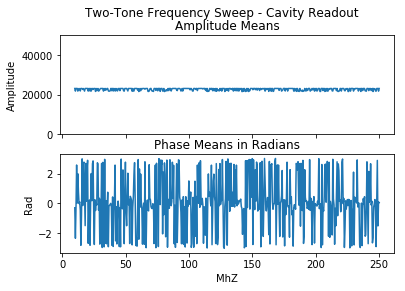

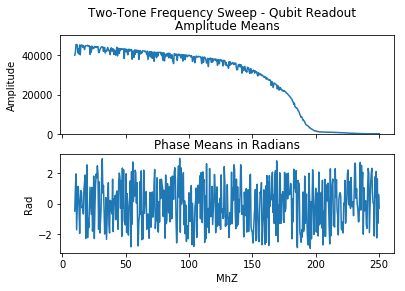

In [5]:
#Two-Tone Spectroscopy

qFreqStart = 10 #MHz
qFreqStop = 250 #MHz
nFreqs = 500
cavFreq = 100 #MHz
qGain= 20000
cavGain = 30000

#channel 7 has an LF Balun
#Channel 6 has a filter

cavChannelOut = 7
cavChannelIn = 0

qChannelOut = 6
qChannelIn = 1

freqs = np.linspace(qFreqStart, qFreqStop, nFreqs)
cavAmpMeans = np.zeros(len(freqs))
cavAmpStds = np.zeros(len(freqs))
cavPhaseMeans = np.zeros(len(freqs))
cavPhaseStds = np.zeros(len(freqs))
qAmpMeans = np.zeros(len(freqs))
qAmpStds = np.zeros(len(freqs))
qPhaseMeans = np.zeros(len(freqs))
qPhaseStds = np.zeros(len(freqs))

for i, f in enumerate(freqs):
    decCavity,decQubit,acCavity,acQubit = twoToneSpec(outputChCavity=cavChannelOut,
                                                      outputChQubit=qChannelOut,
                                                      inputChCavity=cavChannelIn,
                                                      inputChQubit=qChannelIn,
                                                      freqCavity=cavFreq,
                                                      freqQubit=f,)
    cavAmps = np.abs(acCavity[0] + 1j * acCavity[1])
    cavPhases = np.angle(acCavity[0] + 1j * acCavity[1])
    cavAmpMeans[i] = cavAmps[2:].mean()
    cavAmpStds[i] = cavAmps[2:].std()
    cavPhaseMeans[i] = cavPhases[2:].mean()
    cavPhaseStds[i] = cavPhases[2:].std()
    
    qAmps = np.abs(acQubit[0] + 1j * acQubit[1])
    qPhases = np.angle(acQubit[0] + 1j * acQubit[1])
    qAmpMeans[i] = qAmps[2:].mean()
    qAmpStds[i] = qAmps[2:].std()
    qPhaseMeans[i] = qPhases[2:].mean()
    qPhaseStds[i] = qPhases[2:].std()

fig,ax = plt.subplots(2,1,sharex=True)
fig.suptitle("Two-Tone Frequency Sweep - Cavity Readout")
ax[0].set_title("Amplitude Means")
#ax[0].errorbar(freqs, ampMeans, yerr=ampStds)
ax[0].plot(freqs, cavAmpMeans)
ax[0].set_ylabel("Amplitude")
ax[0].set_ylim(0,50000)
#ax[1].errorbar(freqs, phaseMeans, yerr=phaseStds)
ax[1].set_title("Phase Means in Radians")
ax[1].plot(freqs, cavPhaseMeans)
ax[1].set_ylabel("Rad")
plt.xlabel("MhZ")
plt.show()

fig,ax = plt.subplots(2,1,sharex=True)
fig.suptitle("Two-Tone Frequency Sweep - Qubit Readout")
ax[0].set_title("Amplitude Means")
#ax[0].errorbar(freqs, ampMeans, yerr=ampStds)
ax[0].plot(freqs, qAmpMeans)
ax[0].set_ylabel("Amplitude")
ax[0].set_ylim(0,50000)
#ax[1].errorbar(freqs, phaseMeans, yerr=phaseStds)
ax[1].set_title("Phase Means in Radians")
ax[1].plot(freqs, qPhaseMeans)
ax[1].set_ylabel("Rad")
plt.xlabel("MhZ")
plt.show()